In [1]:
import torch
from IPython.core.pylabtools import figsize
from torchinfo import summary
from tqdm import tqdm
import TorchData
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_dataset = TorchData.TORCHFullReconstructionDataset(num_data=5096, signal_count=25, noise_density=0.01, dispersion_intensity=1)
test_dataset = TorchData.TORCHFullReconstructionDataset(num_data=1, signal_count=25, noise_density=0.01)

train_dataloader = train_dataset.dataloader(batch_size=256, shuffle=True)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

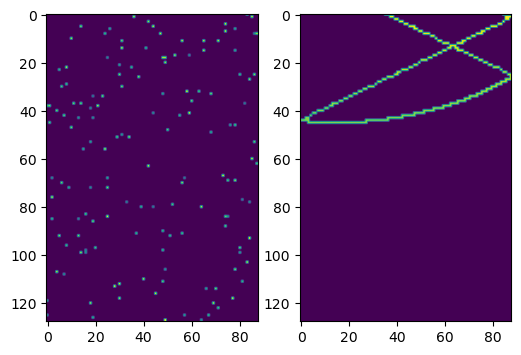

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6, 10))
data = next(iter(train_dataloader))
ax[0].imshow(data[0][0].squeeze(0))
ax[1].imshow(data[1][0].squeeze(0))

In [5]:
class LearnablePositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim=64, seq_length=704):
        super().__init__()
        self.pos_embed = torch.nn.Parameter(
            torch.zeros(1, seq_length, embed_dim),
            requires_grad=True
        )
        torch.nn.init.normal_(self.pos_embed, std=0.02)  # Xavier-style initialization

    def forward(self, x):
        B, seq, embed_size = x.shape
        return x + self.pos_embed

In [6]:
class HybridTransformer(torch.nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_layers=2):
        super().__init__()
        
        # CNN Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2)
        )

        # Transformer
        self.transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=4*embed_dim,
                batch_first=True,
                norm_first=True,  # Better stability
                dropout=0.1
            ),
            num_layers=num_layers
        )

        
        # CNN Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(),
            torch.nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

        # self.pos_embed = torch.nn.Parameter(torch.randn(1, 690, embed_dim))
        self.learnable_position_embed = LearnablePositionalEncoding(embed_dim)
        # self.fixed_pos_embed = PositionalEncoding(embed_dim)

    def forward(self, x):
        # Encoder
        cnn_features = self.encoder(x)  # [B, 64, H/4, W/4]
        
        # Transformer processing
        B, C, H, W = cnn_features.shape
        x = cnn_features.flatten(2).permute(0, 2, 1)

        # x = x + self.pos_embed[:, :H*W, :]
        # x = self.fixed_pos_embed(x)
        x = self.learnable_position_embed(x)
        x = self.transformer(x)
        
        # Feature fusion
        x = x.permute(0, 2, 1).view(B, C, H, W)
        #  x = x + cnn_features  # Residual connection
        
        # Decoder
        return self.decoder(x)

In [7]:
model = HybridTransformer().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

/home/lukelele/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [8]:
summary(model, input_size=(1, 1, 128, 88))

Layer (type:depth-idx)                        Output Shape              Param #
HybridTransformer                             [1, 1, 128, 88]           --
├─Sequential: 1-1                             [1, 64, 32, 22]           --
│    └─Conv2d: 2-1                            [1, 32, 128, 88]          320
│    └─BatchNorm2d: 2-2                       [1, 32, 128, 88]          64
│    └─GELU: 2-3                              [1, 32, 128, 88]          --
│    └─MaxPool2d: 2-4                         [1, 32, 64, 44]           --
│    └─Conv2d: 2-5                            [1, 64, 64, 44]           18,496
│    └─BatchNorm2d: 2-6                       [1, 64, 64, 44]           128
│    └─GELU: 2-7                              [1, 64, 64, 44]           --
│    └─MaxPool2d: 2-8                         [1, 64, 32, 22]           --
├─LearnablePositionalEncoding: 1-2            [1, 704, 64]              45,056
├─TransformerEncoder: 1-3                     [1, 704, 64]              --
│    └─Mod

In [ ]:
scaler = torch.amp.GradScaler()

for epoch in tqdm(range(10)):
    for sn_time, signal_time in train_dataloader:
        optimiser.zero_grad()

        with torch.amp.autocast(device):
            outputs = model(sn_time.to(device))
            loss = loss_function(outputs, signal_time.to(device))

        scaler.scale(loss).backward()
        scaler.step(optimiser)
        scaler.update()

 10%|█         | 1/10 [00:09<01:21,  9.09s/it]


KeyboardInterrupt: 

In [ ]:
### Using pretrained weights
# model.load_state_dict(torch.load("model_weights.pth", weights_only=True))

In [ ]:
model.eval()

with torch.no_grad():
    pred = model.to("cpu")(next(iter(test_dataloader))[0].to("cpu"))

Text(0.5, 1.0, 'Reconstructed Image')

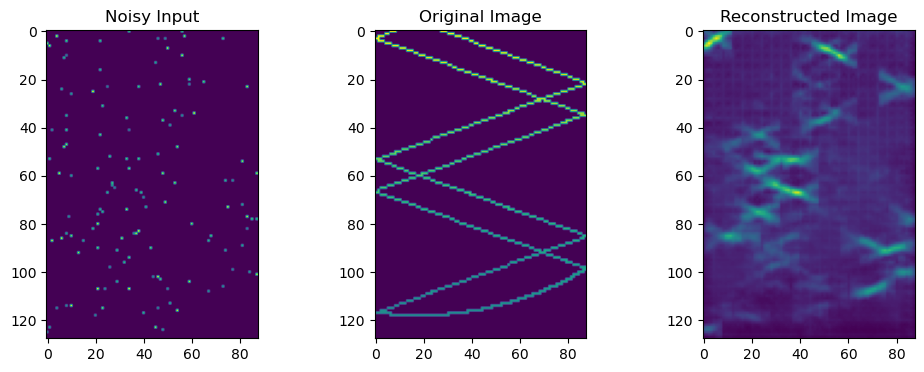

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(next(iter(test_dataloader))[0].squeeze(0).squeeze(0).to("cpu"))
ax[1].imshow(next(iter(test_dataloader))[1].squeeze(0).squeeze(0).to("cpu"))
ax[2].imshow(pred[0].squeeze(0))

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")

(array([[ 1.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        ...,
        [ 0.,  1.,  2., ...,  0.,  0.,  0.],
        [ 0.,  1.,  2., ...,  0.,  0.,  0.],
        [ 1.,  6., 20., ...,  0.,  0.,  0.]]),
 array([ 0.29678658,  0.94551396,  1.59424126,  2.24296856,  2.89169598,
         3.54042339,  4.18915081,  4.83787823,  5.48660564,  6.13533306,
         6.78406048,  7.4327879 ,  8.08151436,  8.73024178,  9.37896919,
        10.02769661, 10.67642403, 11.32515144, 11.97387886, 12.62260628,
        13.27133369, 13.92006111, 14.56878853, 15.21751595, 15.86624241,
        16.51497078, 17.1636982 , 17.81242561, 18.46115303, 19.10988045,
        19.75860786, 20.40733528, 21.0560627 , 21.70479012, 22.35351753,
        23.00224495, 23.65097237, 24.29969978, 24.9484272 , 25.59715462,
        26.24588203, 26.89460945, 27.54333687, 28.19206429, 28.8407917 ,
        29.48951912, 30.13824654, 30.78697395, 31.43569946

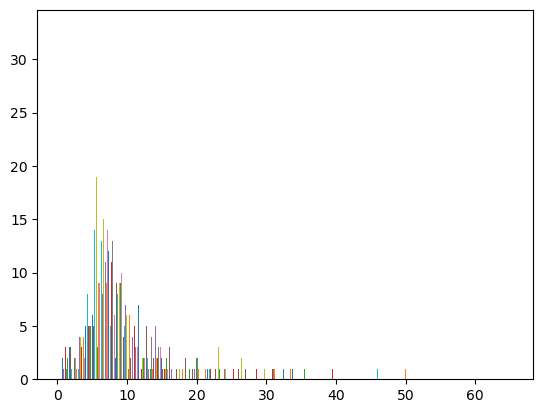

In [ ]:
plt.hist(pred[0].squeeze(0), bins=100)